In [1]:
#import the all necessary libraries
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
#from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM, Bidirectional, GRU
from sklearn.preprocessing import MinMaxScaler
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow import keras
import sys
import time
from numpy import array
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

# Set random seed for TensorFlow
tf.random.set_seed(72)

# Set random seed for Python built-in random module
np.random.seed(42)

In [2]:
dataset_path = ('geant-dataset.csv')
df = pd.read_csv(dataset_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10771 entries, 0 to 10770
Columns: 530 entries, 2005-01-01-00-30 to 0.51
dtypes: float64(524), int64(5), object(1)
memory usage: 43.6+ MB


In [3]:
# fig, axs = plt.subplots(50, 1, figsize=(20, 80))
# fig.subplots_adjust(hspace=0.5)

# # Iterate over the od_number columns
# for od_number in range(350, 400):
#         OD = df.iloc[:, od_number].values.reshape(-1, 1)
#         scaler = MinMaxScaler()
#         OD = scaler.fit_transform(OD)
#         timesteps = 10771
#         ax = axs[od_number - 350]  # Adjust the index 
#         ax.plot(OD[0:timesteps], label=f"od_number {od_number+1}", linewidth=4)
#         ax.set_title(f"od_number {od_number+1}", fontsize=6)
#         ax.set_xlabel('Timesteps', fontweight='bold', fontsize=6)  
#         ax.set_ylabel('Utilization (%)', fontweight='bold', fontsize=6)  
#         #ax.legend()
# plt.show()

In [4]:
od_number = 388
OD = df.iloc[:, od_number]
OD = OD.astype('float32')
OD = OD.values
OD = np.reshape(OD,(-1,1))
OD.shape

(10771, 1)

In [5]:
scaler = MinMaxScaler()
dataset = scaler.fit_transform(OD)

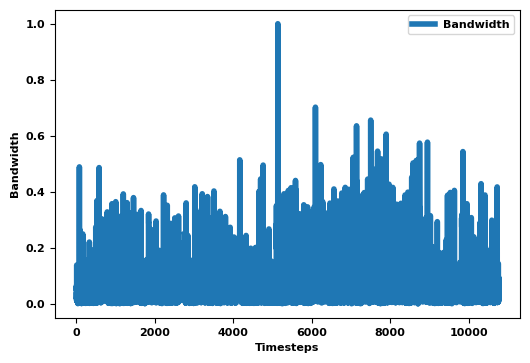

In [6]:
timesteps = 10771
plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams.update({'font.size': 8, 'font.weight' : 'bold'})
plt.plot(dataset[0:timesteps], label = "Bandwidth",linewidth=4)
plt.xlabel('Timesteps', fontweight='bold', fontsize=8)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 8)
plt.legend()
plt.savefig('388th.png',dpi=800)

In [7]:
train, test = dataset[0:10002,:], dataset[10002:10771,:]
print ("train_size: %s and test_size: %s" %(len(train), len(test)))

train_size: 10002 and test_size: 769


In [8]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [9]:
# choosing a number of time steps
n_steps_in, n_steps_out, n_features = 10, 5, 1
# split into samples
X_train, y_train = split_sequence(train, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(test, n_steps_in, n_steps_out)
true_testY = y_test.reshape(y_test.shape[0],y_test.shape[1])
print("true_testY_shape",true_testY.shape)
print('x_train_shape',X_train.shape,'x_train_lenght',len(X_train))
print('y_train_shape',y_train.shape,'y_train_lenght',len(y_train))
print('X_test_shape',X_test.shape,'x_test_lenght',len(X_test))
print('y_test_shape',y_test.shape,'y_test_lenght',len(y_test))
#print(X_train)
#X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
#print('x_train_shape',X_train.shape,'x_train_lenght',len(X_train))
#y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1]))
#print('y_train_shape',y_train.shape,'y_train_lenght',len(y_train))

true_testY_shape (755, 5)
x_train_shape (9988, 10, 1) x_train_lenght 9988
y_train_shape (9988, 5, 1) y_train_lenght 9988
X_test_shape (755, 10, 1) x_test_lenght 755
y_test_shape (755, 5, 1) y_test_lenght 755


In [10]:
# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# #X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
# #X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
# true_testY = y_test.reshape(y_test.shape[0],y_test.shape[1])
# print(true_testY.shape)
# #print(true_testY[:,1])
# #print(true_testY[:,2])
# print('x_train_shape',X_train.shape,'x_train_lenght',len(X_train))
# print('X_test_shape',X_test.shape,'x_test_lenght',len(X_test))

In [11]:
# make a multi-step forecast
def forecast (model, X_test):
    predicted_result  = model.predict(X_test)
    return predicted_result

In [12]:
n_batch = 256
n_epoch = 10

In [13]:
# define LSTM model
def vanilla_lstm(X_train,x_test, batch_size, nb_epoch):
    model = Sequential()
    model.add(CuDNNLSTM(20, input_shape=(n_steps_in, n_features)))
    #model.add(LSTM(300, input_shape=(n_steps_in, n_features), activation="relu"))
    #model.add(Dense(20, activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='Adam', loss='mse')

    model.summary()
    plot_model(model, to_file='fit_lstm.png', show_shapes=True, show_layer_names=True)
    # fit model
    start = time.time()
    model.fit(X_train, y_train,epochs=nb_epoch, batch_size=batch_size,verbose=0,validation_split=0.22)
    end = time.time()
    print("cost of training time:", end - start)
    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 20)                1840      
_________________________________________________________________
dense (Dense)                (None, 5)                 105       
Total params: 1,945
Trainable params: 1,945
Non-trainable params: 0
_________________________________________________________________
cost of training time: 7.531257629394531
dict_keys(['loss', 'val_loss'])


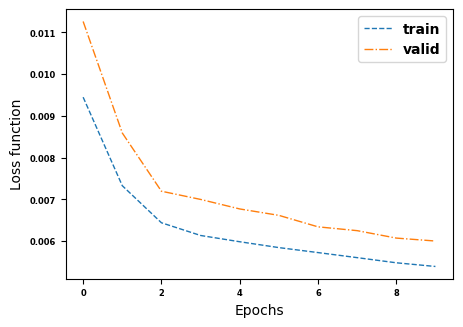

val_loss_lstm__model [0.011257631704211235, 0.008588726632297039, 0.007195114623755217, 0.006998810451477766, 0.006770869717001915, 0.006617446895688772, 0.0063425758853554726, 0.006251361686736345, 0.006073396187275648, 0.006002826150506735]
loss_lstm_model [0.009445171803236008, 0.0073270369321107864, 0.0064400131814181805, 0.006135918200016022, 0.005985823925584555, 0.005845688749104738, 0.005726466421037912, 0.005605254787951708, 0.005482187960296869, 0.005393936298787594]
cost of prediction time: 0.26700520515441895
lstm_stack_prediction shape: (755, 5)
0) Test RMSE: 0.05090
1) Test RMSE: 0.05520
2) Test RMSE: 0.05752
3) Test RMSE: 0.05885
4) Test RMSE: 0.05866


In [14]:
# repeat experiment LSTM
repeats = 1
lstm_predicted_dic = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
for r in range(repeats):
    # fit the model
    lstm_model = vanilla_lstm(X_train, y_train,  n_batch, n_epoch)
    print(lstm_model.history.history.keys())
    
    plt.rcParams["figure.figsize"] = [5, 3.5]
    plt.plot(lstm_model.history.history['loss'], linewidth=1, linestyle='--')
    plt.plot(lstm_model.history.history['val_loss'], linewidth=1, linestyle='dashdot')
    #plt.title('Learning Curve', fontsize=12)
    plt.ylabel('Loss function', fontsize=10)
    plt.xlabel('Epochs', fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(['train', 'valid'], loc='upper right', fontsize=10)
    plt.savefig('lstm_model.png')
    plt.show()
    
    print('val_loss_lstm__model',lstm_model.history.history['val_loss'])
    print('loss_lstm_model',lstm_model.history.history['loss'])
    
    start = time.time()
    lstm_prediction  = forecast(lstm_model,X_test)
    end = time.time()
    print("cost of prediction time:", end - start)
    lstm_predicted_dic[r] = lstm_prediction
    print("lstm_stack_prediction shape:", lstm_prediction.shape)
    
# report performance
lstm_error_scores = list()
    #true_testY_one_testY[:,0]
for i in range(0,n_steps_out):
    true_testY_fst_stp = true_testY[:,i]
    lstm_result_fst_stp = lstm_prediction[:,i]
    temp = 0
    for j in range(len(true_testY_fst_stp)):
        temp += (true_testY_fst_stp[j] - lstm_result_fst_stp[j])**2
    rmse = math.sqrt(temp / len(true_testY_fst_stp))
    print('%d) Test RMSE: %.5f' % (i, rmse))
    lstm_error_scores.append(rmse)
    

In [15]:
# define GUR model
def fit_GRU(X_train,x_test, batch_size, nb_epoch):
    model = Sequential()
    
    model.add(CuDNNGRU(20, input_shape=(n_steps_in, n_features)))
    #model.add(Dense(20))
    #model.add(Dense(20))
    
    
    #model.add(GRU(300, input_shape=(n_steps_in, n_features), activation="relu"))
    #model.add(Dropout(0.5))
    #model.add(Dense(200 , activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    plot_model(model, to_file='model_GRU.png', show_shapes=True, show_layer_names=True)
    # fit model
    start = time.time()
    model.fit(X_train, y_train,epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_split=0.22)
    end = time.time()
    print("cost of training time:", end - start)
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru (CuDNNGRU)         (None, 20)                1380      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 105       
Total params: 1,485
Trainable params: 1,485
Non-trainable params: 0
_________________________________________________________________
cost of training time: 2.602844476699829
dict_keys(['loss', 'val_loss'])


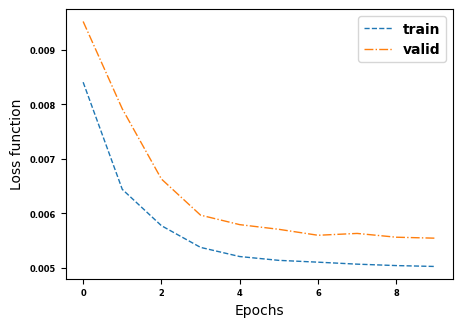

val_loss_gru_model [0.009516253136098385, 0.007916022092103958, 0.0066306134685873985, 0.005968830548226833, 0.005795193370431662, 0.005709403660148382, 0.005600371863692999, 0.005634261295199394, 0.005564787890762091, 0.005547059699892998]
loss_gru_model [0.008403879590332508, 0.006441327277570963, 0.005775977857410908, 0.005378314293920994, 0.0052108000963926315, 0.005140908062458038, 0.005107680801302195, 0.005071394145488739, 0.005045271944254637, 0.005028935614973307]
cost of prediction time: 0.1644279956817627
lstm_stack_prediction shape: (755, 5)
0) Test RMSE: 0.04841
1) Test RMSE: 0.05537
2) Test RMSE: 0.05773
3) Test RMSE: 0.06015
4) Test RMSE: 0.06019


In [16]:
# repeat experiment stack_GRU
repeats = 1
GRU_predicted_dic = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
for r in range(repeats):
    # fit the model
    GRU_model = fit_GRU(X_train, y_train,  n_batch, n_epoch)
    print(GRU_model.history.history.keys())
    
    plt.rcParams["figure.figsize"] = [5, 3.5]
    plt.plot(GRU_model.history.history['loss'], linewidth=1, linestyle='--')
    plt.plot(GRU_model.history.history['val_loss'], linewidth=1, linestyle='dashdot')
    #plt.title('Learning Curve', fontsize=12)
    plt.ylabel('Loss function', fontsize=10)
    plt.xlabel('Epochs', fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(['train', 'valid'], loc='upper right', fontsize=10)
    plt.savefig('lstm_stack_model.png')
    plt.show()
    
    print('val_loss_gru_model',GRU_model.history.history['val_loss'])
    print('loss_gru_model',GRU_model.history.history['loss'])
    
    start = time.time()
    GRU_prediction  = forecast(GRU_model,X_test)
    end = time.time()
    print("cost of prediction time:", end - start)
    GRU_predicted_dic[r] = GRU_prediction
    print("lstm_stack_prediction shape:", GRU_prediction.shape)
    
# report performance
GRU_error_scores = list()
    #true_testY_one_testY[:,0]
for i in range(0,n_steps_out):
    true_testY_fst_stp = true_testY[:,i]
    GRU_result_fst_stp = GRU_prediction[:,i]
    temp = 0
    for j in range(len(true_testY_fst_stp)):
        temp += (true_testY_fst_stp[j] - GRU_result_fst_stp[j])**2
    rmse = math.sqrt(temp / len(true_testY_fst_stp))
    print('%d) Test RMSE: %.5f' % (i, rmse))
    GRU_error_scores.append(rmse)
    

In [17]:
# BiLSTM define model
def fit_Bilstm(X_train,x_test, batch_size, nb_epoch):
    model = Sequential()
    model.add(Bidirectional(CuDNNLSTM(20), input_shape=(n_steps_in, n_features)))
    #model.add(Bidirectional(LSTM(300, input_shape=(n_steps_in, n_features), activation="relu")))
    #model.add(Dropout(0.5))
    #model.add(Dense(20,activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')   
    #model.summary()
    plot_model(model, to_file='fit_Bilstm.png', show_shapes=True, show_layer_names=True)
    #model.build(input_shape = (X_train.shape[0],n_steps_in))
    # fit model
    start = time.time()
    model.fit(X_train, y_train,epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_split=0.22)
    end = time.time()
    print("cost of training time:", end - start)
    return model

cost of training time: 4.220215559005737
dict_keys([])


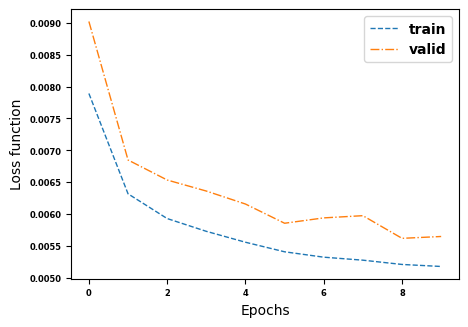

val_loss_Bilstm__model [0.009022247046232224, 0.006848159711807966, 0.006533929146826267, 0.0063604689203202724, 0.00615684874355793, 0.0058551752008497715, 0.005939335096627474, 0.005974108818918467, 0.0056183175183832645, 0.005647297948598862]
loss_Bilstm_model [0.007891987450420856, 0.006317310035228729, 0.00592869333922863, 0.005728302523493767, 0.005557125899940729, 0.00540699390694499, 0.005322502925992012, 0.005275523755699396, 0.005208414513617754, 0.005176716484129429]
cost of prediction time: 0.33837056159973145
lstm_stack_prediction shape: (755, 5)
0) Test RMSE: 0.04944
1) Test RMSE: 0.05635
2) Test RMSE: 0.05849
3) Test RMSE: 0.06054
4) Test RMSE: 0.06033


In [18]:
# repeat experiment Bilstm
repeats = 1
Bilstm_predicted_dic = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
for r in range(repeats):
    # fit the model
    Bilstm_model = fit_Bilstm(X_train, y_train,  n_batch, n_epoch)
    print(lstm_model.history.history.keys())
    
    plt.rcParams["figure.figsize"] = [5, 3.5]
    plt.plot(Bilstm_model.history.history['loss'], linewidth=1, linestyle='--')
    plt.plot(Bilstm_model.history.history['val_loss'], linewidth=1, linestyle='dashdot')
    #plt.title('Learning Curve', fontsize=12)
    plt.ylabel('Loss function', fontsize=10)
    plt.xlabel('Epochs', fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(['train', 'valid'], loc='upper right', fontsize=10)
    plt.savefig('lstm_model.png')
    plt.show()
    
    print('val_loss_Bilstm__model',Bilstm_model.history.history['val_loss'])
    print('loss_Bilstm_model',Bilstm_model.history.history['loss'])
    
    start = time.time()
    Bilstm_prediction  = forecast(Bilstm_model,X_test)
    end = time.time()
    print("cost of prediction time:", end - start)
    Bilstm_predicted_dic[r] = Bilstm_prediction
    print("lstm_stack_prediction shape:", Bilstm_prediction.shape)
    
# report performance
Bilstm_error_scores = list()
    #true_testY_one_testY[:,0]
for i in range(0,n_steps_out):
    true_testY_fst_stp = true_testY[:,i]
    Bilstm_result_fst_stp = Bilstm_prediction[:,i]
    temp = 0
    for j in range(len(true_testY_fst_stp)):
        temp += (true_testY_fst_stp[j] - Bilstm_result_fst_stp[j])**2
    rmse = math.sqrt(temp / len(true_testY_fst_stp))
    print('%d) Test RMSE: %.5f' % (i, rmse))
    Bilstm_error_scores.append(rmse)
    

In [19]:
# BiGRU define model
def fit_BiGRU(X_train,x_test, batch_size, nb_epoch):
    model = Sequential()
    model.add(Bidirectional(CuDNNGRU(20), input_shape=(n_steps_in, n_features)))
    #model.add(Bidirectional(GRU(300, input_shape=(n_steps_in, n_features), activation="relu")))
    #model.add(Dropout(0.5))
    #model.add(Dense(20, activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')   
    #model.summary()
    plot_model(model, to_file='fit_BiGRU.png', show_shapes=True, show_layer_names=True)
    #model.build(input_shape = (X_train.shape[0],n_steps_in))
    # fit model
    start = time.time()
    model.fit(X_train, y_train,epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_split=0.22)
    end = time.time()
    print("cost of training time:", end - start)
    model.summary()
    return model

cost of training time: 3.926093578338623
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 40)                2760      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 205       
Total params: 2,965
Trainable params: 2,965
Non-trainable params: 0
_________________________________________________________________
dict_keys(['loss', 'val_loss'])


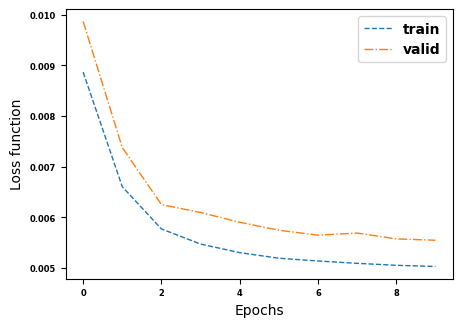

val_loss_Bigru_model [0.00986834242939949, 0.0073776827193796635, 0.0062520927749574184, 0.006095947697758675, 0.0059028491377830505, 0.005745436996221542, 0.005647904705256224, 0.005689379293471575, 0.0055747744627296925, 0.005547353997826576]
loss_Bigru_model [0.00886821374297142, 0.006604693364351988, 0.005771089345216751, 0.005472536664456129, 0.0053025782108306885, 0.005192560143768787, 0.005137650296092033, 0.005091598257422447, 0.005052495747804642, 0.005029639229178429]
cost of prediction time: 0.26320934295654297
lstm_stack_prediction shape: (755, 5)
0) Test RMSE: 0.04862
1) Test RMSE: 0.05589
2) Test RMSE: 0.05813
3) Test RMSE: 0.06017
4) Test RMSE: 0.06032


In [20]:
# repeat experiment stack_GRU
repeats = 1
BiGRU_predicted_dic = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
for r in range(repeats):
    # fit the model
    BiGRU_model = fit_BiGRU(X_train, y_train,  n_batch, n_epoch)
    print(BiGRU_model.history.history.keys())
    
    plt.rcParams["figure.figsize"] = [5, 3.5]
    plt.plot(BiGRU_model.history.history['loss'], linewidth=1, linestyle='--')
    plt.plot(BiGRU_model.history.history['val_loss'], linewidth=1, linestyle='dashdot')
    #plt.title('Learning Curve', fontsize=12)
    plt.ylabel('Loss function', fontsize=10)
    plt.xlabel('Epochs', fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(['train', 'valid'], loc='upper right', fontsize=10)
    plt.savefig('lstm_stack_model.png')
    plt.show()
    
    print('val_loss_Bigru_model',BiGRU_model.history.history['val_loss'])
    print('loss_Bigru_model',BiGRU_model.history.history['loss'])
    
    start = time.time()
    BiGRU_prediction  = forecast(BiGRU_model,X_test)
    end = time.time()
    print("cost of prediction time:", end - start)
    BiGRU_predicted_dic[r] = BiGRU_prediction
    print("lstm_stack_prediction shape:", BiGRU_prediction.shape)
    
# report performance
BiGRU_error_scores = list()
    #true_testY_one_testY[:,0]
for i in range(0,n_steps_out):
    true_testY_fst_stp = true_testY[:,i]
    BiGRU_result_fst_stp = BiGRU_prediction[:,i]
    temp = 0
    for j in range(len(true_testY_fst_stp)):
        temp += (true_testY_fst_stp[j] - BiGRU_result_fst_stp[j])**2
    rmse = math.sqrt(temp / len(true_testY_fst_stp))
    print('%d) Test RMSE: %.5f' % (i, rmse))
    BiGRU_error_scores.append(rmse)
    

In [21]:
# define stack-LSTM model
def fit_lstm_stack(X_train,x_test, batch_size, nb_epoch):
    model = Sequential()
    model.add(CuDNNLSTM(20, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(CuDNNLSTM(20))
    #model.add(LSTM(300, return_sequences=True, input_shape=(n_steps_in, n_features)))
    #model.add(Dropout(0.3))
    #model.add(LSTM(20,  return_sequences=True))
    #model.add(Dropout(0.3))
    #model.add(LSTM(200, ))
    #model.add(Dropout(0.3))
    #model.add(Dense(20))
    #model.add(Dropout(0.1))
    model.add(Dense(n_steps_out))
    model.summary()
    
    model.compile(optimizer='adam', loss='mse')
    
    start = time.time()
    model.fit(X_train, y_train,epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_split=0.22)
    end = time.time()
    print("cost of training time:", end - start)
    
    plot_model(model, to_file='fit_lstm_stack.png', show_shapes=True, show_layer_names=True)
    return model

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 20)            1840      
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20)                3360      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 105       
Total params: 5,305
Trainable params: 5,305
Non-trainable params: 0
_________________________________________________________________
cost of training time: 3.8338096141815186
dict_keys(['loss', 'val_loss'])


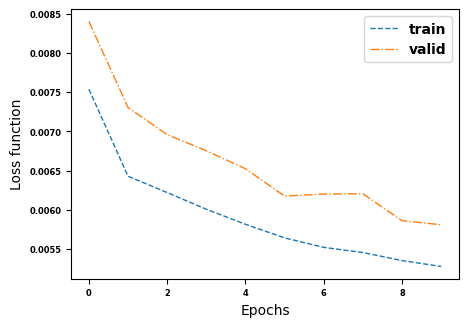

val_loss_lstm_stack_model [0.008402455598115921, 0.007305208593606949, 0.006958560086786747, 0.006753418128937483, 0.006523095071315765, 0.006174447014927864, 0.006201332900673151, 0.006203902419656515, 0.005860613193362951, 0.005809283349663019]
loss_lstm_stack_model [0.007538935635238886, 0.006427915301173925, 0.006219745613634586, 0.006006574723869562, 0.0058149974793195724, 0.005641391035169363, 0.005520460661500692, 0.005454812664538622, 0.0053519606590271, 0.005276764277368784]
cost of prediction time: 0.2953951358795166
lstm_stack_prediction shape: (755, 5)
0) Test RMSE: 0.05018
1) Test RMSE: 0.05640
2) Test RMSE: 0.05789
3) Test RMSE: 0.05980
4) Test RMSE: 0.05993


In [22]:
# repeat experiment stack_LSTM
repeats = 1
lstm_stack_predicted_dic = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
for r in range(repeats):
    # fit the model
    lstm_stack_model = fit_lstm_stack(X_train, y_train,  n_batch, n_epoch)
    print(lstm_stack_model.history.history.keys())
    
    plt.rcParams["figure.figsize"] = [5, 3.5]
    plt.plot(lstm_stack_model.history.history['loss'], linewidth=1, linestyle='--')
    plt.plot(lstm_stack_model.history.history['val_loss'], linewidth=1, linestyle='dashdot')
    #plt.title('Learning Curve', fontsize=12)
    plt.ylabel('Loss function', fontsize=10)
    plt.xlabel('Epochs', fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(['train', 'valid'], loc='upper right', fontsize=10)
    plt.savefig('lstm_stack_model.png')
    plt.show()
    
    print('val_loss_lstm_stack_model',lstm_stack_model.history.history['val_loss'])
    print('loss_lstm_stack_model',lstm_stack_model.history.history['loss'])
    
    start = time.time()
    lstm_stack_prediction  = forecast(lstm_stack_model,X_test)
    end = time.time()
    print("cost of prediction time:", end - start)
    lstm_stack_predicted_dic[r] = lstm_stack_prediction
    print("lstm_stack_prediction shape:", lstm_stack_prediction.shape)
    
# report performance
lstm_stack_error_scores = list()
    #true_testY_one_testY[:,0]
for i in range(0,n_steps_out):
    true_testY_fst_stp = true_testY[:,i]
    lstm_stack_result_fst_stp = lstm_stack_prediction[:,i]
    temp = 0
    for j in range(len(true_testY_fst_stp)):
        temp += (true_testY_fst_stp[j] - lstm_stack_result_fst_stp[j])**2
    rmse = math.sqrt(temp / len(true_testY_fst_stp))
    print('%d) Test RMSE: %.5f' % (i, rmse))
    lstm_stack_error_scores.append(rmse)
    

In [23]:
# define stack-GRU model
def fit_GRU_stack(X_train,x_test, batch_size, nb_epoch):
    model = Sequential()
    model.add(CuDNNGRU(20, return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(CuDNNGRU(20,))
    #model.add(GRU(300, input_shape=(n_steps_in, n_features)))
    #model.add(Dropout(0.3))
    #model.add(GRU(20,  return_sequences=True))
    #model.add(Dropout(0.3))
    #model.add(GRU(100, ))
    #model.add(Dropout(0.3))
    #model.add(Dense(20))
    #model.add(Dropout(0.1))
    model.add(Dense(n_steps_out))
    model.summary()
    
    model.compile(optimizer='adam', loss='mse')
    
    start = time.time()
    model.fit(X_train, y_train,epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_split=0.22)
    end = time.time()
    print("cost of training time:", end - start)
    
    plot_model(model, to_file='fit_lstm_stack.png', show_shapes=True, show_layer_names=True)
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_2 (CuDNNGRU)       (None, 10, 20)            1380      
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, 20)                2520      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 105       
Total params: 4,005
Trainable params: 4,005
Non-trainable params: 0
_________________________________________________________________
cost of training time: 3.607619285583496
dict_keys(['loss', 'val_loss'])


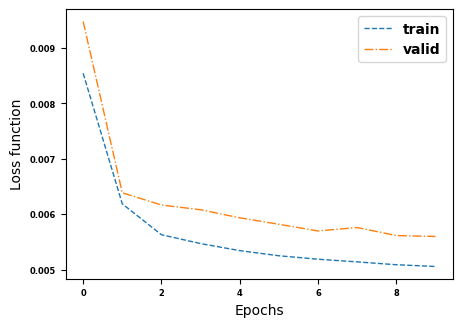

val_loss_gru_stack_model [0.009476977400481701, 0.006385908927768469, 0.006165225990116596, 0.006079952232539654, 0.005934353917837143, 0.005817854776978493, 0.005697139073163271, 0.005758816376328468, 0.005614005960524082, 0.005597980227321386]
loss_gru_stack_model [0.008542686700820923, 0.006186479702591896, 0.005628971382975578, 0.005469382740557194, 0.005342208780348301, 0.005249438341706991, 0.005187146365642548, 0.005138683132827282, 0.005087648518383503, 0.00505619402974844]
cost of prediction time: 0.2589454650878906
gru_stack_prediction shape: (755, 5)
0) Test RMSE: 0.04895
1) Test RMSE: 0.05572
2) Test RMSE: 0.05815
3) Test RMSE: 0.06041
4) Test RMSE: 0.06038


In [24]:
# repeat experiment stack_GRU
repeats = 1
gru_stack_predicted_dic = {1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[]}
for r in range(repeats):
    # fit the model
    gru_stack_model = fit_GRU_stack(X_train, y_train,  n_batch, n_epoch)
    print(gru_stack_model.history.history.keys())
    
    plt.rcParams["figure.figsize"] = [5, 3.5]
    plt.plot(gru_stack_model.history.history['loss'], linewidth=1, linestyle='--')
    plt.plot(gru_stack_model.history.history['val_loss'], linewidth=1, linestyle='dashdot')
    #plt.title('Learning Curve', fontsize=12)
    plt.ylabel('Loss function', fontsize=10)
    plt.xlabel('Epochs', fontsize=10)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.legend(['train', 'valid'], loc='upper right', fontsize=10)
    plt.savefig('gru_stack_model.png')
    plt.show()
    
    print('val_loss_gru_stack_model',gru_stack_model.history.history['val_loss'])
    print('loss_gru_stack_model',gru_stack_model.history.history['loss'])
    
    start = time.time()
    gru_stack_prediction  = forecast(gru_stack_model,X_test)
    end = time.time()
    print("cost of prediction time:", end - start)
    gru_stack_predicted_dic[r] = gru_stack_prediction
    print("gru_stack_prediction shape:", gru_stack_prediction.shape)
    
# report performance
gru_stack_error_scores = list()
    #true_testY_one_testY[:,0]
for i in range(0,n_steps_out):
    true_testY_fst_stp = true_testY[:,i]
    gru_stack_result_fst_stp = gru_stack_prediction[:,i]
    temp = 0
    for j in range(len(true_testY_fst_stp)):
        temp += (true_testY_fst_stp[j] - gru_stack_result_fst_stp[j])**2
    rmse = math.sqrt(temp / len(true_testY_fst_stp))
    print('%d) Test RMSE: %.5f' % (i, rmse))
    gru_stack_error_scores.append(rmse)
    

In [25]:
#true_testY = np.reshape(true_testY,(true_testY.shape[1],1))
#true_testY = scaler.inverse_transform([true_testY])

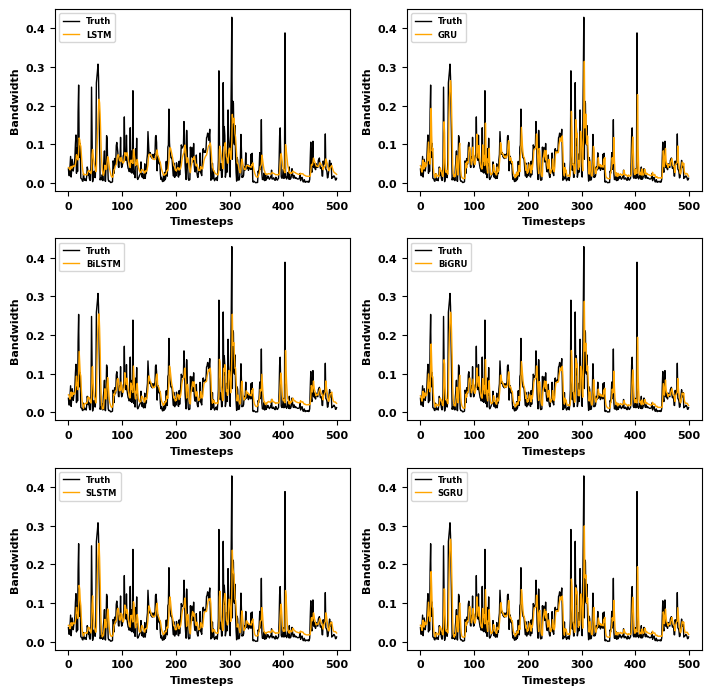

In [26]:
# customizing runtime configuration stored
# in matplotlib.rcParams
plt.rcParams["figure.figsize"] = [7.16, 7]
plt.rcParams["figure.autolayout"] = True


timesteps = 500
#plt.rcParams["figure.figsize"] = (40,20)
#plt.rcParams.update({'font.size': 12, 'font.weight' : 'bold'})
plt.subplot(3, 2, 1)
plt.plot(true_testY[0:timesteps,0], label = "Truth",linewidth=1, color = 'black')
plt.plot(lstm_prediction[0:timesteps,0], label = "LSTM",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=8)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 8)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(3, 2, 5)
plt.plot(true_testY[0:timesteps,0], label = "Truth",linewidth=1, color = 'black')
plt.plot(lstm_stack_prediction[0:timesteps,0], label = "SLSTM",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=8)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 8)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(3, 2, 3)
plt.plot(true_testY[0:timesteps,0], label = "Truth",linewidth=1, color = 'black')
plt.plot(Bilstm_prediction[0:timesteps,0], label = "BiLSTM",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=8)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 8)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(3, 2, 6)
plt.plot(true_testY[0:timesteps,0], label = "Truth",linewidth=1, color = 'black')
plt.plot(gru_stack_prediction[0:timesteps,0], label = "SGRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=8)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 8)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(3, 2, 2)
plt.plot(true_testY[0:timesteps,0], label = "Truth",linewidth=1, color = 'black')
plt.plot(GRU_prediction[0:timesteps,0], label = "GRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=8)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 8)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(3, 2, 4)
plt.plot(true_testY[0:timesteps,0], label = "Truth",linewidth=1, color = 'black')
plt.plot(BiGRU_prediction[0:timesteps,0], label = "BiGRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=8)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 8)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

#plt.plot(x,y)
# print("Ground-truth",true_testY[100:timesteps,0])
# print("LSTM_prediction",LSTM_prediction[100:timesteps,0])
# print("lstm_stack_prediction",lstm_stack_prediction[100:timesteps,0])
# print("BiLSTM_prediction",BiLSTM_prediction[100:timesteps,0])
# print("CNN_LSTM_prediction",CNN_LSTM_prediction[100:timesteps,0])
# print("GRU_prediction",true_testY[100:timesteps,0])
# print("BiGRU_prediction",BiGRU_prediction[100:timesteps,0])


filename = "prediction.pdf"
plt.savefig(filename)

# Display the plot if needed
plt.show()


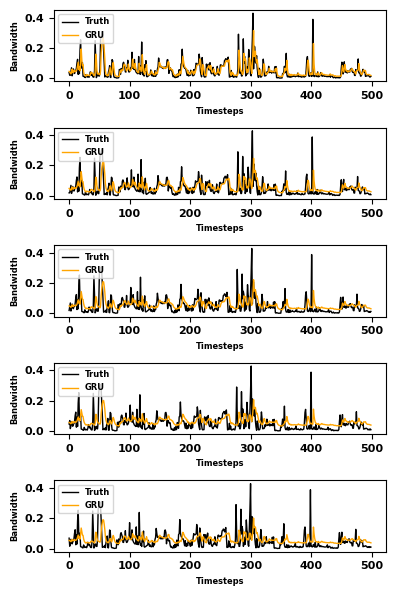

In [27]:
# customizing runtime configuration stored
# in matplotlib.rcParams
plt.rcParams["figure.figsize"] = [4, 6]
plt.rcParams["figure.autolayout"] = True


plt.subplot(5, 1, 1)
plt.plot(true_testY[0:timesteps,0], label = "Truth",linewidth=1, color = 'black')
plt.plot(GRU_prediction[0:timesteps,0], label = "GRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=6)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 6)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


plt.subplot(5, 1, 2)
plt.plot(true_testY[0:timesteps,1], label = "Truth",linewidth=1, color = 'black')
plt.plot(GRU_prediction[0:timesteps,1], label = "GRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=6)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 6)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(5, 1, 3)
plt.plot(true_testY[0:timesteps,2], label = "Truth",linewidth=1, color = 'black')
plt.plot(GRU_prediction[0:timesteps,2], label = "GRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=6)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 6)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(5, 1, 4)
plt.plot(true_testY[0:timesteps,3], label = "Truth",linewidth=1, color = 'black')
plt.plot(GRU_prediction[0:timesteps,3], label = "GRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=6)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 6)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

plt.subplot(5, 1, 5)
plt.plot(true_testY[0:timesteps,4], label = "Truth",linewidth=1, color = 'black')
plt.plot(GRU_prediction[0:timesteps,4], label = "GRU",linewidth=1, color='orange')
plt.xlabel('Timesteps', fontweight='bold', fontsize=6)
plt.ylabel('Bandwidth', fontweight='bold', fontsize = 6)
plt.legend(fontsize=6,loc='upper left')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)


filename = "prediction_multi-steps.pdf"
plt.savefig(filename)

# Display the plot if needed
plt.show()

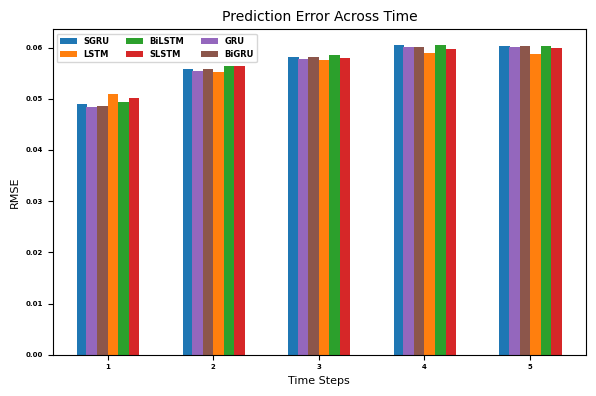

In [28]:
fig = plt.figure(figsize=(6,4))
#plt.rcParams["figure.figsize"] = [7.16, 7.16]
names = ['1st','2nd','3th','4th','5th']
#lstm_stack_error_scores=[0.05120,0.05588,0.05808,0.05902,0.05972]
stack_LSTM = lstm_stack_error_scores[:]
#print("GuSLSTM",stack_LSTM)
#Bilstm_error_scores=[0.05372,0.05860,0.05963,0.06178,0.06245]
BiLSTM = Bilstm_error_scores[:]
#print("GuBiLSTM",BiLSTM)
#lstm_error_scores=[0.04963,0.05561,0.05801,0.05848,0.05988]
LSTM = lstm_error_scores[:]
#print("GuLSTM",LSTM)
#GRU_error_scores=[0.04832,0.05510,0.05883,0.06072,0.06037]
GRU = GRU_error_scores[:]
#print("GuGRU",GRU)
#gru_stack_error_scores=[0.04826,0.05523,0.05760,0.05912,0.05953]
gru_stack = gru_stack_error_scores[:]
#print("GuCLRN",LSTM)
#BiGRU_error_scores=[0.04850,0.05585,0.05766,0.05893,0.05933]
BiGRU =  BiGRU_error_scores[:]
#print("GuBiGRU",BiGRU)
X_axis =(np.arange(len(names))+0.75)
#plt.ylabel('RMSE', fontweight='bold',fontsize= 40)
plt.bar(X_axis + 0.01, gru_stack, 0.1, label = 'SGRU') 
plt.bar(X_axis + 0.3, LSTM, 0.1, label = 'LSTM') 
plt.bar(X_axis + 0.4, BiLSTM, 0.1, label = 'BiLSTM')
plt.bar(X_axis + 0.5, stack_LSTM, 0.1, label = 'SLSTM')
plt.bar(X_axis + 0.1, GRU, 0.1, label = 'GRU') 
plt.bar(X_axis + 0.2, BiGRU, 0.1, label = 'BiGRU') 

#plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Girls')
#plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'Boys')
plt.xticks(fontsize=32)
plt.yticks(fontsize=32)
plt.xlabel("Time Steps",fontsize=8)
plt.ylabel("RMSE",fontsize=8)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.title("Prediction Error Across Time",fontsize=10)
plt.legend(fontsize=6,loc='upper left', ncol = 3)
#plt.show()
plt.savefig('stateless.png',dpi=800)

[[0.03654329 0.01938069 0.01941239 0.04607158 0.06883314]
 [0.01938069 0.01941239 0.04607158 0.06883314 0.01558015]
 [0.01941239 0.04607158 0.06883314 0.01558015 0.03276021]
 [0.04607158 0.06883314 0.01558015 0.03276021 0.0614255 ]
 [0.06883314 0.01558015 0.03276021 0.0614255  0.04651599]
 [0.01558015 0.03276021 0.0614255  0.04651599 0.03118947]
 [0.03276021 0.0614255  0.04651599 0.03118947 0.043786  ]
 [0.0614255  0.04651599 0.03118947 0.043786   0.04844509]
 [0.04651599 0.03118947 0.043786   0.04844509 0.06595787]
 [0.03118947 0.043786   0.04844509 0.06595787 0.10168614]]
[0.06883314 0.01558015 0.03276021 0.0614255  0.04651599 0.03118947
 0.043786   0.04844509 0.06595787 0.10168614]


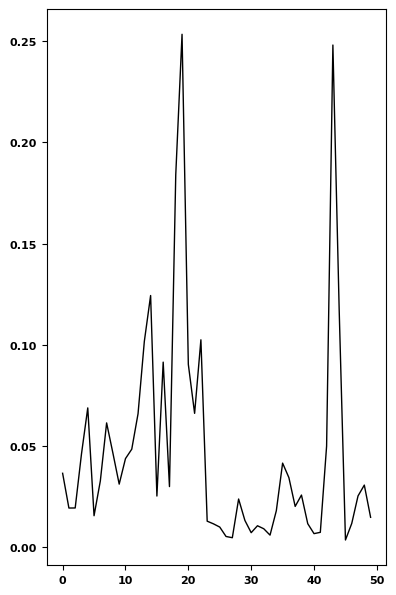

In [29]:
print(true_testY[0:10])
print(true_testY[0:10,4])
plt.plot(true_testY[0:50,0], label = "Truth",linewidth=1, color = 'black')


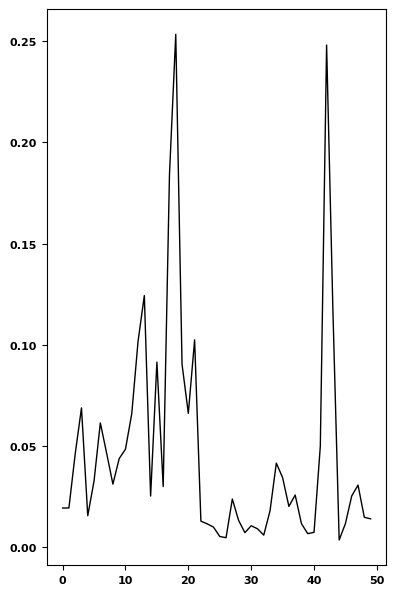

In [30]:
plt.plot(true_testY[0:50,1], label = "Truth",linewidth=1, color = 'black')


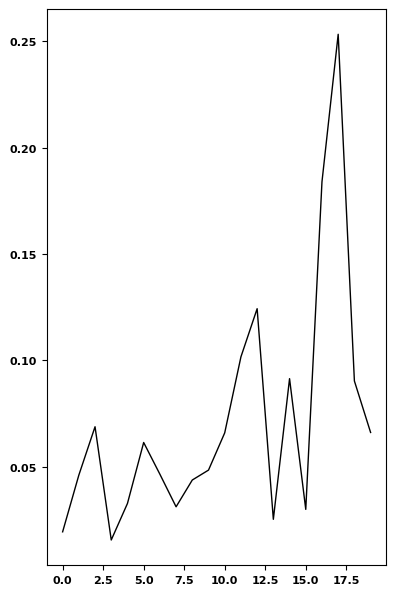

In [31]:
plt.plot(true_testY[0:20,2], label = "Truth",linewidth=1, color = 'black')


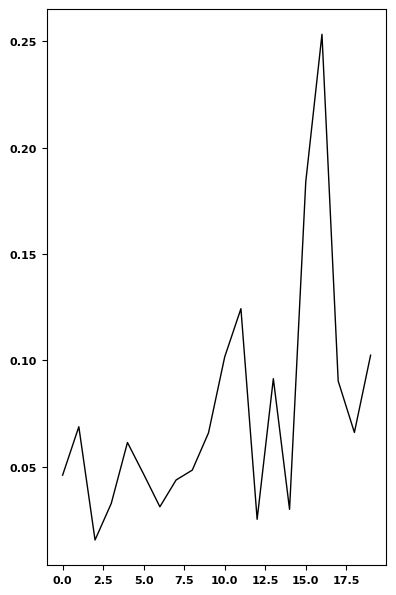

In [32]:
plt.plot(true_testY[0:20,3], label = "Truth",linewidth=1, color = 'black')


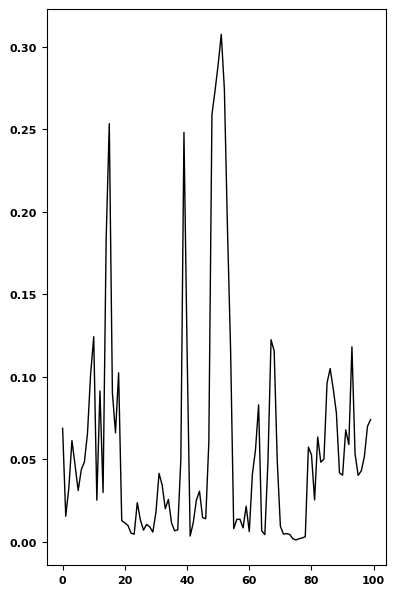

In [33]:
plt.plot(true_testY[0:100,4], label = "Truth",linewidth=1, color = 'black')